# TP: MNIST with Neural Networks (NN)

## Arnaud Capitan

In [670]:
import numpy as np
import tensorflow as tf
import keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.18.0
Using keras version 3.8.0


## Loading and preparing the MNIST dataset
Load the MNIST dataset made available by keras.datasets. Check the size of the training and testing sets. 

In [671]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(f"Size of the training set : {len(train_images)}")
print(f"Size of the testing set : {len(test_images)}")


Size of the training set : 60000
Size of the testing set : 10000


The MNIST database contains 60,000 training images and 10,000 testing images.
Using the pyplot package, visualize the first sample of the training set:

First label of training set is : 5


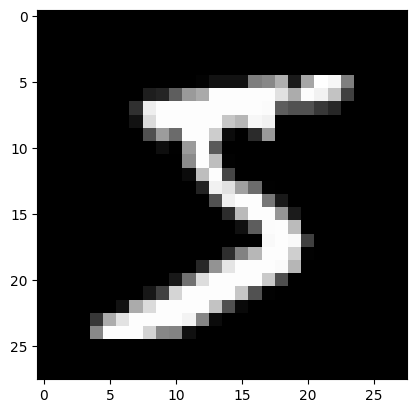

In [672]:
# Let us visualize the first training sample using the Matplotlib library with the imshow function
from matplotlib import pyplot as plt

print(f"First label of training set is : {train_labels[0]}")
plt.imshow(train_images[0], cmap='gray')

The database contains images of handwritten digits. Hence, they belong to one of 10 categories, depending on the digit they represent. 
Reminder: in order to do multi-class classification, we use the softmax function, which outputs a multinomial probability distribution. That means that the output to our model will be a vector of size $10$, containing probabilities (meaning that the elements of the vector will be positive sum to $1$).
For easy computation, we want to true labels to be represented with the same format: that is what we call **one-hot encoding**. For example, if an image $\mathbf{x}$ represents the digit $5$, we have the corresponding one_hot label (careful, $0$ will be the first digit): 
$$ \mathbf{y} = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] $$
Here, you need to turn train and test labels to one-hot encoding using the following function: 

In [673]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes = 10)
test_labels = to_categorical(test_labels, num_classes = 10)
print("First label (5) of training set in one-hot encoding :")
print(train_labels[0])

First label (5) of training set in one-hot encoding :
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Images are black and white, with size $28 \times 28$. We will work with them using a simple linear classification model, meaning that we will have them as vectors of size $(784)$.
You should then transform the images to the size $(784)$ using the numpy function ```reshape```.

Then, after casting the pixels to floats, normalize the images so that they have zero-mean and unitary deviation. Be careful to your methodology: while you have access to training data, you may not have access to testing data, and must avoid using any statistic on the testing dataset.

In [674]:
# Reshape images to vectors of pixels
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape(-1,784)

# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?

# I'd rather not change

train_images = train_images/255

test_images = test_images.reshape(-1,784)
test_images = test_images.astype('float32')/255

# First part: working with Numpy

Look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf) for some basic information on how to use numpy.

### Defining the model 

We will here create a simple, linear classification model. We will take each pixel in the image as an input feature (making the size of the input to be $784$) and transform these features with a weight matrix $\mathbf{W}$ and a bias vector $\mathbf{b}$. Since there is $10$ possible classes, we want to obtain $10$ scores. Then, 
$$ \mathbf{W} \in \mathbb{R}^{784 \times 10} $$
$$ \mathbf{b} \in \mathbb{R}^{10} $$

and our scores are obtained with:
$$ \mathbf{z} = \mathbf{W}^{T} \mathbf{x} +  \mathbf{b} $$

where $\mathbf{x} \in \mathbb{R}^{784}$ is the input vector representing an image.
We note $\mathbf{y} \in \mathbb{R}^{10}$ as the target one_hot vector. 

Here, you fist need to initialize $\mathbf{W}$ and $\mathbf{b}$ using ```np.random.normal``` and ```np.zeros```, then compute $\mathbf{z}$.

In [675]:
# To avoid implementing a complicated gradient back-propagation,
# we will try a very simple architecture with one layer 
def initLayer(n_input,n_output):
    """
    Initialize the weights, return the number of parameters
    Inputs: n_input: the number of input units - int
          : n_output: the number of output units - int
    Outputs: W: a matrix of weights for the layer - numpy ndarray
           : b: a vector bias for the layer - numpy ndarray
           : nb_params: the number of parameters  - int
    """
    # Create W at the right size with a normal distribution
    W = np.random.normal(size = (n_input,n_output))
    # Create b at the right size, with zeros
    b = np.zeros(n_output)
    nb_params = n_output*(n_input+1)
    return W, b, nb_params

In [676]:
print(f"train_images.shape = {train_images.shape}")

n_training = train_images.shape[0] 
n_feature = train_images.shape[1] #* train_images.shape[2]
n_labels = 10
W, b, nb_params = initLayer(n_feature, n_labels)

train_images.shape = (60000, 784)


In [677]:
def forward(W, b, X):
    """
    Perform the forward propagation
    Inputs: W: the weights - numpy ndarray
          : b: the bias - numpy ndarray
          : X: the batch - numpy ndarray
    Outputs: z: outputs - numpy ndarray
    """
    #print(f"b.shape = {b.shape}, X.shape = {X.shape}, W.shape = {W.shape}")
    z = np.dot(X,W)+b.T
    return z

### Computing the output 

To obtain classification probabilities, we use the softmax function:
$$ \mathbf{o} = softmax(\mathbf{z}) \text{         with          } o_i = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)} $$

The usual difficulty with the softmax function is the possibility of overflow when the scores $z_i$ are already large. Since a softmax is not affected by a shift affecting the whole vector $\mathbf{z}$:
$$ \frac{\exp(z_i - c)}{\sum_{j=0}^{9} \exp(z_j - c)} =  \frac{\exp(c) \exp(z_i)}{\exp(c) \sum_{j=0}^{9} \exp(z_j)} = \frac{\exp(z_i)}{\sum_{j=0}^{9} \exp(z_j)}$$
what trick can we use to ensure we will not encounter any overflow ? 

### Answer :

Since shifting the function does not affect the result obtained by $softmax$, we can $\underline{\text{substract the maximal value}}$, and take the exponential of our transformed values which will always be less than 1.

In this case, the constant c will be the maximum value of our scores $z_i$.
___

In [678]:
def softmax(z):
    """
    Perform the softmax transformation to the pre-activation values
    Inputs: z: the pre-activation values - numpy ndarray
    Outputs: out: the activation values - numpy ndarray
    """
    z_transformed = z - z.max()
    exp_sum = np.exp(z_transformed).sum()
    out = np.zeros(10)
    for i in range(10):
        out[i] = np.exp(z_transformed[i])/exp_sum
    return out

### Making updates

We define a learning rate $\eta$. The goal is to be able to apply updates:
$$ \mathbf{W}^{t+1} = \mathbf{W}^{t} + \nabla_{\mathbf{W}} l_{MLE} $$

In order to do this, we will compute this gradient (and the bias) in the function ```update```. In the next function ```updateParams```, we will actually apply the update with regularization. 

Reminder: the gradient $\nabla_{\mathbf{W}} l_{MLE}$ is the matrix containing the partial derivatives 
$$ \left[\frac{\delta l_{MLE}}{\delta W_{ij}}\right]_{i=1..784, j=1..10} $$
**Remark**: Careful, the usual way of implementing this in python has the dimensions of $\mathbf{W}$ reversed compared to the notation of the slides.

Coordinate by coordinate, we obtain the following update: 
$$ W_{ij}^{t+1} = W_{ij}^{t} + \eta \frac{\delta l_{MLE}}{\delta W_{ij}} $$

Via the chain rule, we obtain, for an input feature $i \in [0, 783]$ and a output class $j \in [0, 9]$: $$\frac{\delta l_{MLE}}{\delta W_{ij}} = \frac{\delta l_{MLE}}{\delta z_{j}} \frac{\delta z_j}{\delta W_{ij}}$$ 

It's easy to compute that $\frac{\delta z_j}{\delta W_{ij}} = x_i$

We compute the softmax derivative, to obtain:
$$ \nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y} $$

Hence, $\frac{\delta l_{MLE}}{\delta z_{j}} = o_j - y_j$ and we obtain that $$\frac{\delta l_{MLE}}{\delta W_{ij}} = (o_j - y_j) x_i$$

This can easily be written as a scalar product, and a similar computation (even easier, actually) can be done for $\mathbf{b}$. Noting $\nabla_{\mathbf{z}} l_{MLE} = \mathbf{o} - \mathbf{y}$ as ```grad``` in the following function, compute the gradients $\nabla_{\mathbf{W}} l_{MLE}$ and $\nabla_{\mathbf{b}} l_{MLE}$ in order to call the function ```updateParams```.

Note: the regularizer and the weight_decay $\lambda$ are used in ```updateParams```.

In [679]:
def update(eta, W, b, grad, X, regularizer, weight_decay):
    """
    Perform the update of the parameters
    Inputs: eta: the step-size of the gradient descent - float 
          : W: the weights - ndarray
          : b: the bias -  ndarray
          : grad: the gradient of the activations w.r.t. to the loss -  list of ndarray
          : X: the data -  ndarray
          : regularizer: 'L2' or None - the regularizer to be used in updateParams
          : weight_decay: the weight decay to be used in updateParams - float
    Outputs: W: the weights updated -  ndarray
           : b: the bias updated -  ndarray
    """
    #print(X.shape)
    #print(grad.shape)
    grad_w = X.copy().reshape(784, 1)@grad.copy().reshape(10, 1).T # (oj - yj)xi
    grad_b = grad
    W = updateParams(W, grad_w, eta, regularizer, weight_decay)
    b = updateParams(b, grad_b, eta, regularizer, weight_decay)
    return W, b

The update rule is affected by regularization. We implement two cases: No regularization, or L2 regularization. Use the two possible update rules to implement the following function:

In [680]:
def updateParams(param, grad_param, eta, regularizer=None, weight_decay=0.):
    """
    Perform the update of the parameters
    Inputs: param: the network parameters - ndarray
          : grad_param: the updates of the parameters - ndarray
          : eta: the step-size of the gradient descent - float
          : weight_decay: the weight-decay - float
    Outputs: the parameters updated - ndarray
    """
    if regularizer==None:
        updated_param = param - eta*grad_param
        return updated_param
    elif regularizer=='L2':
        updated_param = param - eta*(grad_param - weight_decay*np.linalg.norm(param))
        return updated_param
    else:
        raise NotImplementedError

### Computing the Accuracy

Here, we simply use the model to predict the class (by taking the argmax of the output !) for every example in ```X```, and count the number of times the model is right, to output the accuracy.

In [1]:
def computeAcc(W, b, X, labels):
    """
    Compute the loss value of the current network on the full batch
    Inputs: act_func: the activation function - function
          : W: the weights - list of ndarray
          : B: the bias - list of ndarray
          : X: the batch - ndarray
          : labels: the labels corresponding to the batch
    Outputs: loss: the negative log-likelihood - float
           : accuracy: the ratio of examples that are well-classified - float
    """ 
    #print(f"computeAcc : W.shape = {W.shape}, b.shape = {b.shape}, X.shape = {X.shape}")
    accuracy = 0
    for j in range(len(X)):
      # Forward propagation
      z = forward(W,b,X[j])
      # Compute the softmax and the prediction
      out = softmax(z)
      pred = np.argmax(out)
      if labels[j][pred] == 1:
            accuracy +=1
    # Compute the accuracy
    accuracy /= len(X)      
    return accuracy

### Preparing training

The following hyperparameters are given. Next, we can assemble all the function previously defined to implement a training loop. We will train the classifier on **one epoch**, meaning that the model will see each training example once. 

In [682]:
# Optimization
eta = 0.01
regularizer = 'L2'
weight_decay = 0.0001

# Training
log_interval = 5000

$\underline{\text{Remark :}}$

We need to initialize our model with the first sample.

In [683]:
# Data structures for plotting
g_train_acc=[]
g_valid_acc=[]

n_input = train_images[0].shape[0]
n_output = train_labels[0].shape[0]
#print(n_input,n_output)

W, b, _ = initLayer(n_input,n_output)

#######################
### Learning process ##
#######################
for j in range(n_training):
    # Getting the example
    X, y = train_images[j], train_labels[j]

    # Forward propagation
    z = forward(W,b,X)

    # Compute the softmax
    out = softmax(z)
        
    # Compute the gradient at the top layer
    derror = out - y # This is o - y
    grad = derror
    # Update the parameters
    W, b = update(eta,W,b,grad,X,regularizer,weight_decay)
    if j % log_interval == 0:
        # Every log_interval examples, look at the training accuracy
        train_accuracy = computeAcc(W, b, train_images, train_labels) 

        # And the testing accuracy
        test_accuracy = computeAcc(W, b, test_images, test_labels) 

        g_train_acc.append(train_accuracy)
        g_valid_acc.append(test_accuracy)
        result_line = str(int(j)) + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
        print(result_line)

g_train_acc.append(train_accuracy)
g_valid_acc.append(test_accuracy)
result_line = "Final result:" + " " + str(train_accuracy) + " " + str(test_accuracy) + " " + str(eta)
print(result_line)     

0 0.06491666666666666 0.0667 0.01
5000 0.7298833333333333 0.7402 0.01
10000 0.78145 0.7897 0.01
15000 0.8223 0.8291 0.01
20000 0.8345833333333333 0.8416 0.01
25000 0.8470166666666666 0.8528 0.01
30000 0.8545833333333334 0.8573 0.01
35000 0.86175 0.8686 0.01
40000 0.86405 0.8654 0.01
45000 0.86935 0.8714 0.01
50000 0.8716 0.8729 0.01
55000 0.8752 0.8772 0.01
Final result: 0.8752 0.8772 0.01


What can you say about the performance of this simple linear classifier ?

### Answer :

It is slow and only trains for a single epoch. It has an accuracy of 87% on the test set, which is satisfying for a linear classifier trained on a single epoch.

___

# Second part: Autoencoder with Keras

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:

Text(0.5, 0, 'Second Principal Component')

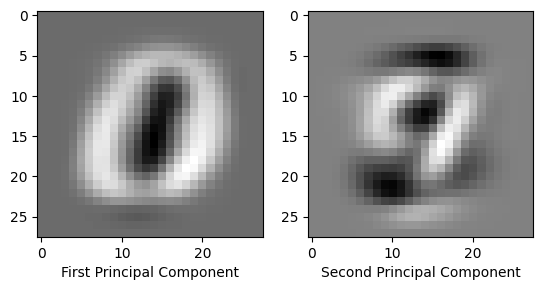

In [684]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
pca = PCA(n_components = num_components).fit(train_images)

# Reshape so they resemble images and we can print them
eigen_mnist = pca.components_.reshape((num_components,28,28))

# Show the reshaped principal components
f, ax = plt.subplots(1,2)
ax[0].imshow(eigen_mnist[0], cmap='gray')
ax[0].set_xlabel('First Principal Component')
ax[1].imshow(eigen_mnist[1], cmap='gray')
ax[1].set_xlabel('Second Principal Component')

In [685]:
# Print the variance explained by those components
pca.explained_variance_

array([5.116877 , 3.7413926], dtype=float32)

Comment on the visualization in relation to the variance explained by only keeping the two principal components:

### Answer :

The variance is really small since not every number can be built from  those two components. There is to much information lost from keeping only those two first components.
___

### Implementing the Autoencoder with Keras

In [735]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 

In [747]:
# Input layer
input_layer = keras.Input(shape=(784,))

# Encoding layer
latent_view = keras.layers.Dense(2, activation="linear", name="layer")(input_layer)

# Decoding layer
output_layer = keras.layers.Dense(784, activation="linear")(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer (Dense)                   │ (None, 2)              │         1,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 784)            │         2,352 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,922 (15.32 KB)

 Trainable params: 3,922 (15.32 KB)

 Non-trainable params: 0 (0.00 B)

What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples. 

We can use mean square error loss.

In [748]:
loss = keras.losses.MeanSquaredError()

optimizer = SGD(learning_rate=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images,test_images))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1100 - val_loss: 0.1041
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0997 - val_loss: 0.0911
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0842 - val_loss: 0.0699
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0673 - val_loss: 0.0641
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0638 - val_loss: 0.0636
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0634 - val_loss: 0.0634
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0635 - val_loss: 0.0633
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0634 - val_loss: 0.0632
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0632 - val_loss: 0.0631
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0630 - val_loss: 0.0629


Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [749]:
weights, bias = ae_model.get_layer('layer').get_weights()
print(weights)

[[ 0.06992554 -0.05746606]
 [ 0.04919953  0.00500012]
 [-0.04298918  0.0370523 ]
 ...
 [-0.00789557 -0.04005911]
 [-0.0266825  -0.01019292]
 [ 0.07591257  0.04678663]]


Now, visualize the images rebuilt by the network !

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


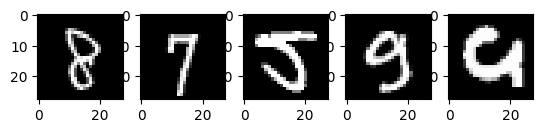

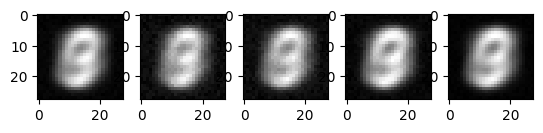

In [750]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(28, 28), cmap='gray')
    
# Get the prediction from the model 
reconstructed = ae_model.predict(test_images.reshape(-1, 784)[n:n+5])
reconstructed = reconstructed.reshape(-1, 28, 28)  # Reshape back to image dimensions

# ... and plot them 
f, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')

### Answer :

It behaves poorly. We need to increase the number of neurons. We can see that the images change, but the shape is roughly the same, and it is not easy to guess which number is which based on the predicted images.
___

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt.

In [757]:
# Input layer
input_layer = keras.Input(shape=(784,))

# Encoding layer
latent_view = keras.layers.Dense(50, activation="linear", name="layer")(input_layer)

# Decoding layer
output_layer = keras.layers.Dense(784, activation="linear")(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer (Dense)                   │ (None, 50)             │        39,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 784)            │        39,984 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,234 (309.51 KB)

 Trainable params: 79,234 (309.51 KB)

 Non-trainable params: 0 (0.00 B)

In [758]:
loss = keras.losses.MeanSquaredError()

optimizer = SGD(learning_rate=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images,test_images))

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1160 - val_loss: 0.0799
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0733 - val_loss: 0.0655
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0648 - val_loss: 0.0630
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0625 - val_loss: 0.0608
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0604 - val_loss: 0.0585
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0583 - val_loss: 0.0562
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0559 - val_loss: 0.0538
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0534 - val_loss: 0.0515
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0512 - val_loss: 0.0493
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0491 - val_loss: 0.0473


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


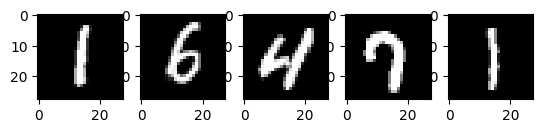

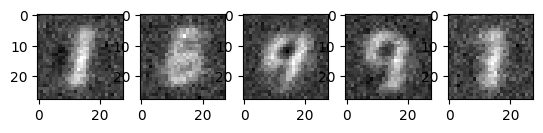

In [ ]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(28, 28), cmap='gray')
    
# Get the prediction from the model 
reconstructed = ae_model.predict(test_images.reshape(-1, 784)[n:n+5])
reconstructed = reconstructed.reshape(-1, 28, 28)  # Reshape back to image dimensions

# ... and plot them 
f, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')

### De-noising Autoencoder

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built.

In [760]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [761]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2642 - val_loss: 0.2502
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2438 - val_loss: 0.2350
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2339 - val_loss: 0.2318
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2313 - val_loss: 0.2299
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2293 - val_loss: 0.2278
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2271 - val_loss: 0.2253
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2246 - val_loss: 0.2226
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2222 - val_loss: 0.2204
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2199 - val_loss: 0.2178
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.2175 - val_loss: 0.2154
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


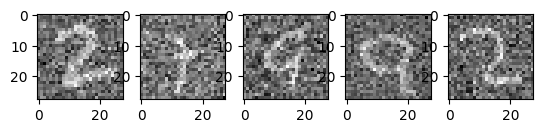

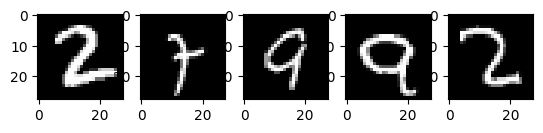

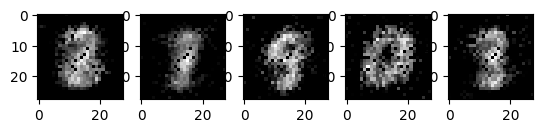

In [768]:
# Visualize some of the images with noise against the originals
n = np.random.randint(0,len(test_images)-5)
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(noisy_test_images[a].reshape(28, 28), cmap='gray')
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(test_images[a].reshape(28, 28), cmap='gray')

# Build a new model with more layers and Relu activations
# Input layer
input_layer = keras.Input(shape=(784,))

# Encoding layer
latent_view = keras.layers.Dense(32, activation="relu")(input_layer)

# Decoding layer
output_layer = keras.layers.Dense(784, activation="relu")(latent_view)

ae_model = Model(input_layer, output_layer, name='ae_model')

# Compile it but here, use noised data as inputs !
loss = keras.losses.MeanSquaredError()
optimizer = SGD(learning_rate=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(noisy_train_images,
                       noisy_train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(noisy_test_images,noisy_test_images))

# Visualize the images rebuilt by the model !
reconstructed = ae_model.predict(noisy_test_images.reshape(-1, 784)[n:n+5])
reconstructed = reconstructed.reshape(-1, 28, 28)  # Reshape back to image dimensions
f, ax = plt.subplots(1,5)
for i in range(5):
    ax[i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')


It gives suprisingly good results compared to before.

Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?

### Answer :

We could use corss-entropy loss funciton for value in the 0-1 range (not 0 though)